# **STUDENT AI** - MATH MODEL CREATION

## Objectives

Create a regression model for the math target variable and assess its performance

## Inputs

Saved dataset from previous notebooks

## Outputs

Pipeline and .pkl file to use for predicitng a students math score based on the given feature variables


---

# Import required libraries

In [32]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

### From CodeInsitute ML lessons
### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [3]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3,< 5,71,71,74
1,female,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,76,78,75


Drop other numerical variables and prepare dataset

In [4]:
df['NrSiblings'] = df['NrSiblings'].astype(str)
df_math = df.drop(['ReadingScore', 'WritingScore'], axis=1)
df_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               30641 non-null  object
 1   EthnicGroup          30641 non-null  object
 2   ParentEduc           30641 non-null  object
 3   LunchType            30641 non-null  object
 4   TestPrep             30641 non-null  object
 5   ParentMaritalStatus  30641 non-null  object
 6   PracticeSport        30641 non-null  object
 7   IsFirstChild         30641 non-null  object
 8   NrSiblings           30641 non-null  object
 9   WklyStudyHours       30641 non-null  object
 10  MathScore            30641 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 2.6+ MB


### Split dataset into Training and Test subsets

In [5]:
math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_math.drop(['MathScore'], axis=1),
    df_math['MathScore'],
    test_size = 0.2,
    random_state = 101
)

print("New Data Set Shapes")
print(f"math_train_features: {math_train_features.shape}, with {math_train_scores.shape} math scores")
print(f"math_test_features: {math_test_features.shape} with {math_test_scores.shape} math scores")


New Data Set Shapes
math_train_features: (24512, 10), with (24512,) math scores
math_test_features: (6129, 10) with (6129,) math scores


## Build Pipeline for regression model to predict Math numerical target variable

For a standard regression model pipeline the steps are realtively simple. 

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Feature Scaling|Ensure all numerical data has a similar scale and is centered around zero - neccessary / improves model performance|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - not neccesary|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|

### To select the best algothim and hyperparameters we will fit a model with each different type / paramater set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

### Prepare Pipeline steps:

In [6]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(
        encoding_method='arbitrary',
        variables = [
          'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType',
          'TestPrep','ParentMaritalStatus','PracticeSport',
          'IsFirstChild','WklyStudyHours'
          ] 
          ) 
          ),
      # SmartCorrelation not needed
      # ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6,selection_method="variance") ),

      ("feature_scaling", StandardScaler() ),

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),

    ])
    
    return pipeline_base

### Hyperparameter testing custom class:

In [7]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Define list of algorithms to test:

In [8]:
models_algorithm_list = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

# prepare list of parameters for each algorithm
parameters_list = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Run custom function with given list of parameters

In [9]:
model_search = HyperparameterOptimizationSearch(models=models_algorithm_list, parameters=parameters_list)
model_search.fit(math_train_features, math_train_scores, scoring='r2', n_jobs=-1, cv=5)

#output result
model_grid_search_summary, model_grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
model_grid_search_summary


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
5,GradientBoostingRegressor,0.206876,0.224436,0.23405,0.009721
4,AdaBoostRegressor,0.1718,0.200428,0.210309,0.01444
0,LinearRegression,0.185717,0.192361,0.195146,0.003502
2,RandomForestRegressor,0.158257,0.175299,0.191239,0.012066
3,ExtraTreesRegressor,0.15087,0.167117,0.183147,0.012515
1,DecisionTreeRegressor,0.151272,0.163922,0.176732,0.010626
6,XGBRegressor,0.154089,0.161561,0.177939,0.008491


### Analysis:
At first glance none of the algorithms are able to produce a score above 0.23 with 0.224 average being the best from the GrandientBoostingRegressor. Next I will test different hyperpramater configurations to see if the performance can be improved...a starting point is provided from the ML Courseware in the scikitlearn lesson by codeinstitute.

In [11]:
models_algorithm = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

parameters_list = {
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            }
  }

In [13]:
param_search = HyperparameterOptimizationSearch(models=models_algorithm, parameters=parameters_list)
param_search.fit(math_train_features, math_train_scores, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [14]:
param_grid_search_summary, param_grid_search_pipelines = param_search.score_summary(sort_by='mean_score')
param_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
17,GradientBoostingRegressor,0.206429,0.224489,0.234442,0.010013,0.1,3,50,1,50,140
5,GradientBoostingRegressor,0.206429,0.224489,0.234442,0.010013,0.1,3,None,1,50,140
2,GradientBoostingRegressor,0.206429,0.224489,0.234442,0.010013,0.1,3,None,1,2,140
14,GradientBoostingRegressor,0.206429,0.224489,0.234442,0.010013,0.1,3,50,1,2,140
0,GradientBoostingRegressor,0.206876,0.224436,0.23405,0.009721,0.1,3,None,1,2,100
...,...,...,...,...,...,...,...,...,...,...,...
160,GradientBoostingRegressor,0.015876,0.017373,0.018686,0.000924,0.001,3,50,1,50,50
145,GradientBoostingRegressor,0.015876,0.017373,0.018686,0.000924,0.001,3,None,1,2,50
154,GradientBoostingRegressor,0.015876,0.017373,0.018686,0.000924,0.001,3,None,50,50,50
151,GradientBoostingRegressor,0.015876,0.017373,0.018686,0.000924,0.001,3,None,50,2,50


### Analysis
This test takes at least 4 minutes, as 1080 fit combinations are tested. Unfortunately the inital view of the table (sorted by best results) reveal that different hyperparamter combinations are not able to improve the performance at all.
Using the custom functions provided in the CustomerChurn lessons, we can programmatically pass the results to the functions to evaluate and plot the performance of the models and compare train and test sets as well.<br>
First the variables are set up that are needed to pass to the custom function:

In [15]:
best_model = model_grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [16]:
best_model_and_params = param_grid_search_summary.iloc[0,0]
best_model_and_params

'GradientBoostingRegressor'

In [17]:
model_grid_search_pipelines[best_model].best_params_

{}

In [18]:
param_grid_search_pipelines[best_model_and_params].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [35]:
best_regressor_pipeline = model_grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep', 'ParentMaritalStatus',
                                           'PracticeSport', 'IsFirstChild',
                                           'WklyStudyHours'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model', GradientBoostingRegressor(random_state=0))])

### Custom functions to evaluate Training vs Test set prediction performance

In [37]:
def regression_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(math_train_features, math_train_scores, pipeline)
	print("* Test Set")
	regression_evaluation(math_test_features, math_test_scores, pipeline)

def regression_evaluation(X, y, pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(math_train_features)
  pred_test = pipeline.predict(math_test_features)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=math_train_scores , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=math_train_scores , y=math_train_scores, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=math_test_scores , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=math_test_scores , y=math_test_scores, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

### Run Custom Functions

Model Evaluation 

* Train Set
R2 Score: 0.228
Mean Absolute Error: 10.928
Mean Squared Error: 182.792
Root Mean Squared Error: 13.52


* Test Set
R2 Score: 0.247
Mean Absolute Error: 10.749
Mean Squared Error: 175.494
Root Mean Squared Error: 13.247




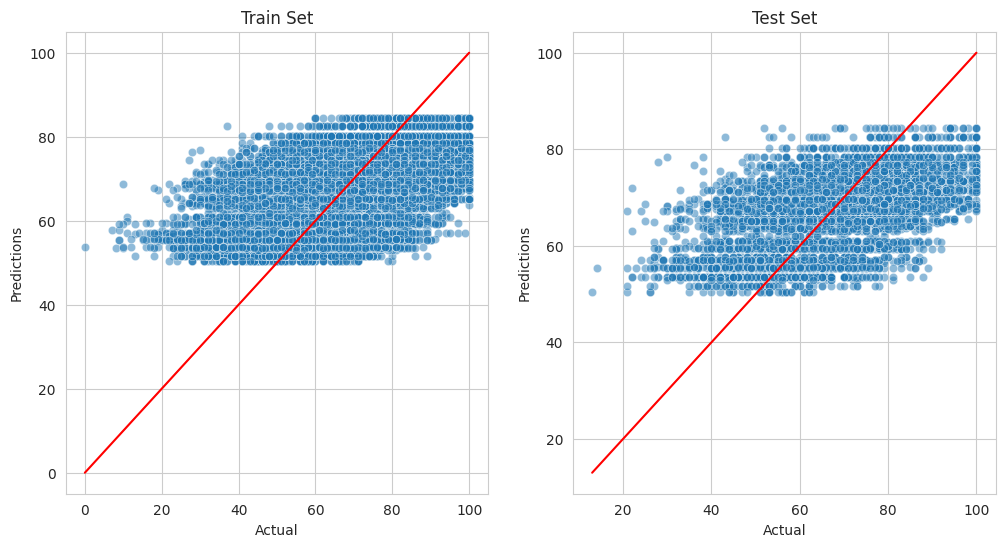

In [39]:
regression_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, best_regressor_pipeline)
regression_evaluation_plots(math_train_features, math_train_scores, math_test_features, math_test_scores, best_regressor_pipeline)

### Assess most important features used in the model:

* These are the 3 most important features in descending order. The model was trained on them: 
['LunchType', 'EthnicGroup', 'ParentEduc']


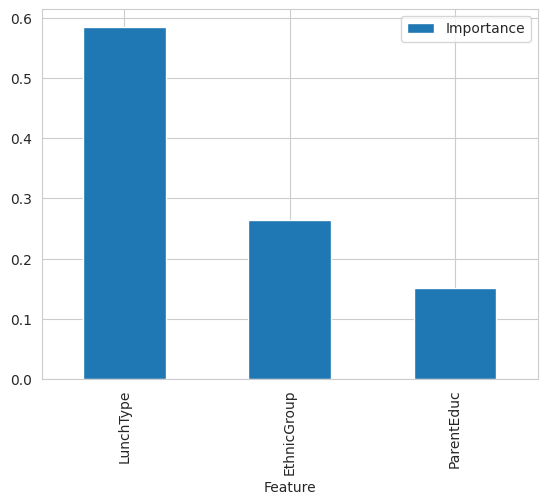

In [40]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline_2.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline_2['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline_2['feature_selection'].get_support()],
          'Importance': best_regressor_pipeline_2['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Conclusion
The R2 score of 0.24 achievable with the booster algorithm is not a great result. It means that on average the model only correctly predicts the target variable 24% of the time. This can also be seen visually in the plot, as the data points are not aligned along the diagonal axis which would indicate a good correlation between the model and the predcited value.<br><br>
The Root Mean Squared Error of 10.2 indicates that on average the model is up to 10.2 units incorrect on the actual score achived by the student. This might be good enough for very general classification of student performance but might not be useful for students in edge cases where they are on the line of a failing grade and might need help that is not flagged by the dahsboard.
on a side note, comparing training vs test results, all values are slightly better than the training set, indicating that the steps taken to prevent overfitting of the model were successful and the model performs reasonably well on unseen data. <br> <br>
The last test indicating the 3 most important features used to train the model are in line with the hypothesis made in the EDA portion of the dataset analysis. <br>

**As the business requirement hopes to achieve an accuracy of >0.7, this approach is therefore not accurate enough. Analogue to the Churnometer course walkthrough, I will then assess the viability of a classification model vs regression model. This will be handled in the next notebook.**